## MOOC 학습자 이탈 예측 모델 개발

### 데이터셋 다운로드

In [3]:
import kagglehub
import os
import pandas as pd

dataset_path = kagglehub.dataset_download("rocki37/open-university-learning-analytics-dataset")
print("Dataset downloaded to:", dataset_path)

data_folder = "data"
os.makedirs(data_folder, exist_ok=True)

files = os.listdir(dataset_path)
csv_files = [f for f in files if f.endswith('.csv')]
print("Found CSV files:", csv_files)

saved_files = []
for csv_file in csv_files:
    src_path = os.path.join(dataset_path, csv_file) 
    dest_path = os.path.join(data_folder, csv_file) 
    df = pd.read_csv(src_path) 
    df.to_csv(dest_path, index=False)
    saved_files.append(dest_path)
    print(f"Saved {csv_file} to {dest_path}")

Dataset downloaded to: C:\Users\Playdata\.cache\kagglehub\datasets\rocki37\open-university-learning-analytics-dataset\versions\1
Found CSV files: ['assessments.csv', 'courses.csv', 'studentAssessment.csv', 'studentInfo.csv', 'studentRegistration.csv', 'studentVle.csv', 'vle.csv']
Saved assessments.csv to data\assessments.csv
Saved courses.csv to data\courses.csv
Saved studentAssessment.csv to data\studentAssessment.csv
Saved studentInfo.csv to data\studentInfo.csv
Saved studentRegistration.csv to data\studentRegistration.csv
Saved studentVle.csv to data\studentVle.csv
Saved vle.csv to data\vle.csv


### 데이터 로드

In [4]:
studentInfo_df = pd.read_csv('./data/studentInfo.csv')[["id_student", "code_module", "highest_education", "studied_credits", "imd_band", "final_result"]]
studentVle_df = pd.read_csv('./data/studentVle.csv')[["id_student", "sum_click", "date"]]
studentAssessment_df = pd.read_csv('./data/studentAssessment.csv')[["id_assessment","id_student", "score"]]
final_merged_data = pd.merge(studentInfo_df, studentAssessment_df, on='id_student', how='inner')

studentVle_agg = studentVle_df.groupby('id_student').agg(
    sum_click=('sum_click', 'sum'),  
    mean_click=('sum_click', 'mean')
).reset_index()

final_merged_data = pd.merge(final_merged_data, studentVle_agg, on='id_student', how='left')

final_merged_data['sum_click'] = final_merged_data['sum_click'].fillna(0)
final_merged_data['mean_click'] = final_merged_data['mean_click'].fillna(0)

### 데이터 전처리

In [5]:
final_merged_data['imd_band'] = final_merged_data['imd_band'].fillna('20-30%')
final_merged_data['score'] = final_merged_data['score'].fillna(0)
final_merged_data['imd_band'] = final_merged_data['imd_band'].replace('10-20', '10-20%')
final_merged_data.to_csv('./data/merged_data.csv', index=False)

### 데이터 분석 및 시각화

In [6]:
withdrawn_rate = final_merged_data["final_result"].value_counts(normalize=True) * 100
print("📌 이탈률 분포:\n", withdrawn_rate)

📌 이탈률 분포:
 final_result
Pass           56.929177
Fail           15.905923
Distinction    14.636382
Withdrawn      12.528519
Name: proportion, dtype: float64


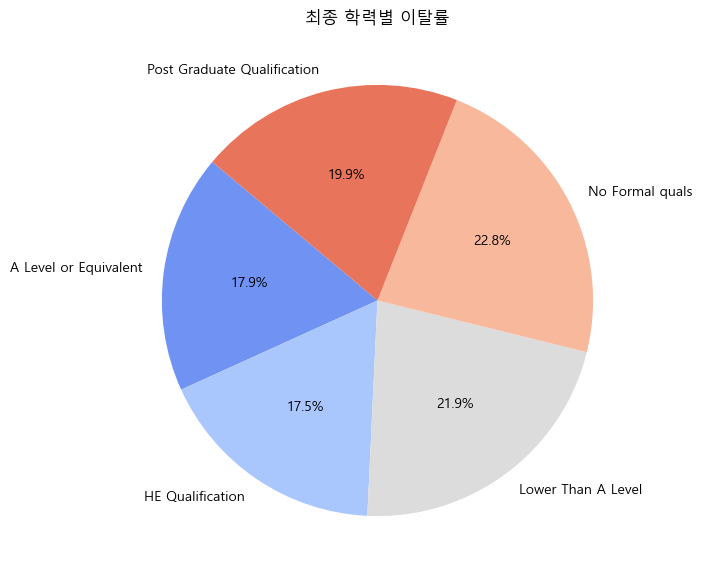

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib

font_path = 'C:/Windows/Fonts/malgunbd.ttf'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)

# font_name = "Apple SD Gothic Neo"
# matplotlib.rc('font', family=font_name)

palette = {"Withdrawn": "red", "Pass": "blue", "Fail": "orange", "Distinction": "green"}

education_withdrawn = final_merged_data.groupby("highest_education")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100
plt.figure(figsize=(7, 7))
plt.pie(education_withdrawn.values, labels=education_withdrawn.index, autopct='%1.1f%%', colors=sns.color_palette("coolwarm", len(education_withdrawn)), startangle=140)
plt.title("최종 학력별 이탈률")
plt.show()

C:\Users\Playdata\AppData\Local\Temp\ipykernel_6864\1184413172.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=education_withdrawn.index, y=education_withdrawn.values, palette="coolwarm")


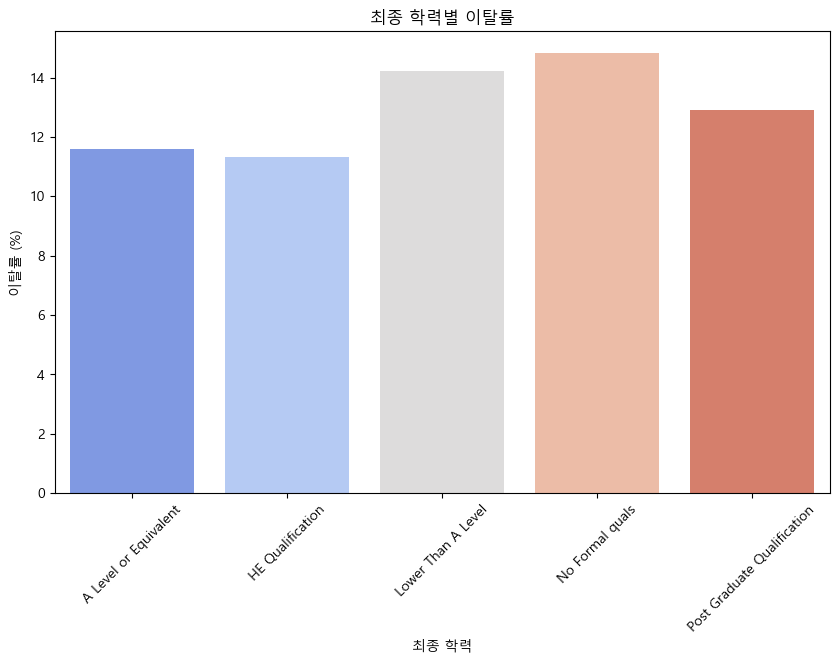

In [8]:
plt.figure(figsize=(10, 6))
education_withdrawn = final_merged_data.groupby("highest_education")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100
sns.barplot(x=education_withdrawn.index, y=education_withdrawn.values, palette="coolwarm")
plt.title("최종 학력별 이탈률")
plt.xlabel("최종 학력")
plt.ylabel("이탈률 (%)")
plt.xticks(rotation=45)
plt.show()

C:\Users\Playdata\AppData\Local\Temp\ipykernel_6864\2892628582.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=imd_withdrawn.index, x=imd_withdrawn.values, palette="coolwarm")


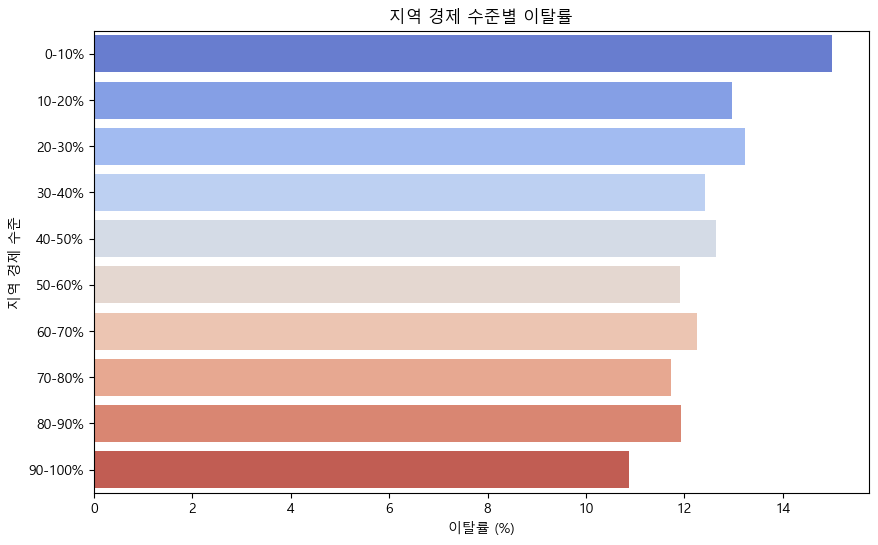

In [9]:
imd_withdrawn = final_merged_data.groupby("imd_band")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100
plt.figure(figsize=(10, 6))
sns.barplot(y=imd_withdrawn.index, x=imd_withdrawn.values, palette="coolwarm")
plt.title("지역 경제 수준별 이탈률")
plt.xlabel("이탈률 (%)")
plt.ylabel("지역 경제 수준")
plt.show()

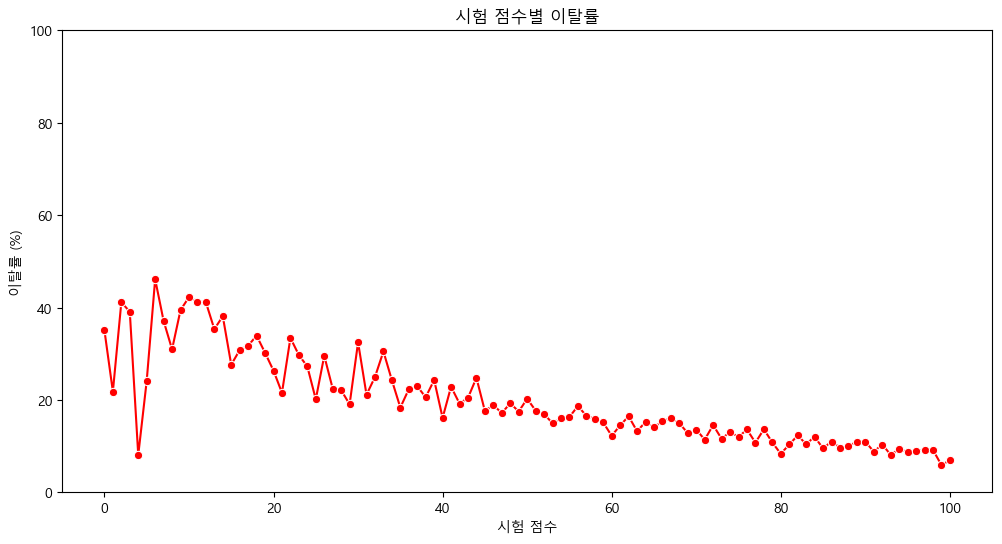

In [10]:
plt.figure(figsize=(12, 6))
score_withdrawn = final_merged_data.groupby("score")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100
sns.lineplot(x=score_withdrawn.index, y=score_withdrawn.values, color="red", marker="o")
plt.title("시험 점수별 이탈률")
plt.xlabel("시험 점수")
plt.ylabel("이탈률 (%)")
plt.ylim(0, 100)
plt.show()

C:\Users\Playdata\AppData\Local\Temp\ipykernel_6864\2119123669.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  score_withdrawn = final_merged_data.groupby("score_bins")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100


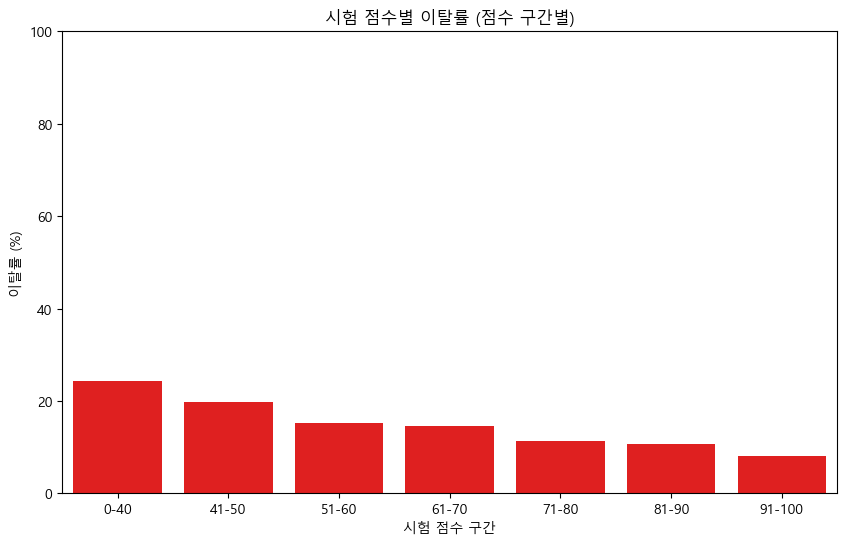

In [11]:
final_merged_data["score_bins"] = pd.cut(final_merged_data["score"], bins=[0, 40, 50, 60, 70, 80, 90, 100], labels=["0-40", "41-50", "51-60", "61-70", "71-80", "81-90", "91-100"])
score_withdrawn = final_merged_data.groupby("score_bins")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=score_withdrawn.index, y=score_withdrawn.values, color="red")
plt.title("시험 점수별 이탈률 (점수 구간별)")
plt.xlabel("시험 점수 구간")
plt.ylabel("이탈률 (%)")
plt.ylim(0, 100) 
plt.show()

C:\Users\Playdata\AppData\Local\Temp\ipykernel_6864\1035278623.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  credit_withdrawn = final_merged_data.groupby("credit_bins")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100


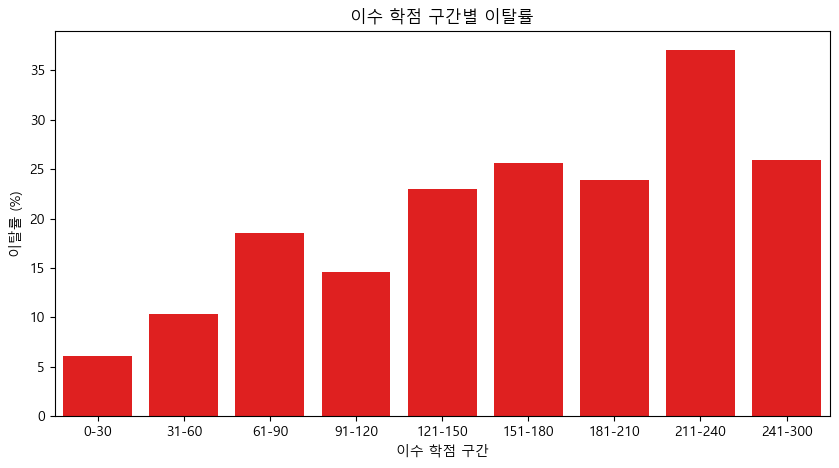

In [12]:
final_merged_data["credit_bins"] = pd.cut(final_merged_data["studied_credits"], bins=[0, 30, 60, 90, 120, 150, 180, 210, 240, 300], labels=["0-30", "31-60", "61-90", "91-120", "121-150", "151-180", "181-210", "211-240", "241-300"])
credit_withdrawn = final_merged_data.groupby("credit_bins")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100

plt.figure(figsize=(10, 5))
sns.barplot(x=credit_withdrawn.index, y=credit_withdrawn.values, color="red")
plt.title("이수 학점 구간별 이탈률")
plt.xlabel("이수 학점 구간")
plt.ylabel("이탈률 (%)")
plt.show()

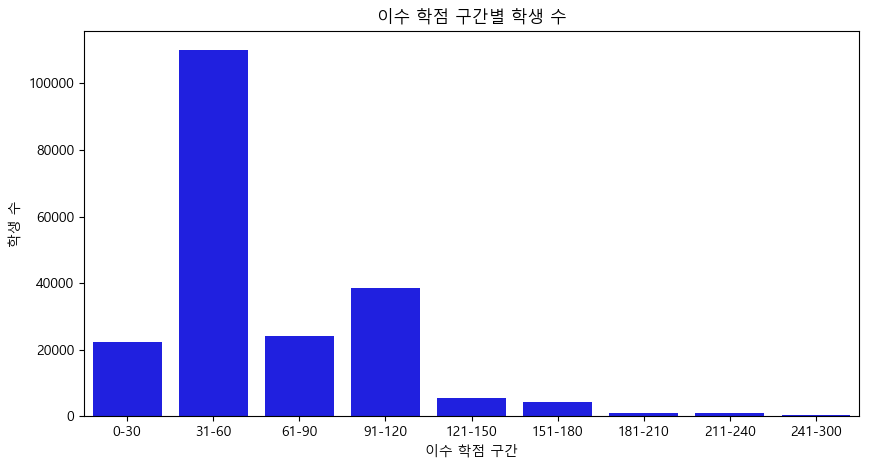

In [13]:
credit_counts = final_merged_data["credit_bins"].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=credit_counts.index, y=credit_counts.values, color="blue")
plt.title("이수 학점 구간별 학생 수")
plt.xlabel("이수 학점 구간")
plt.ylabel("학생 수")
plt.show()

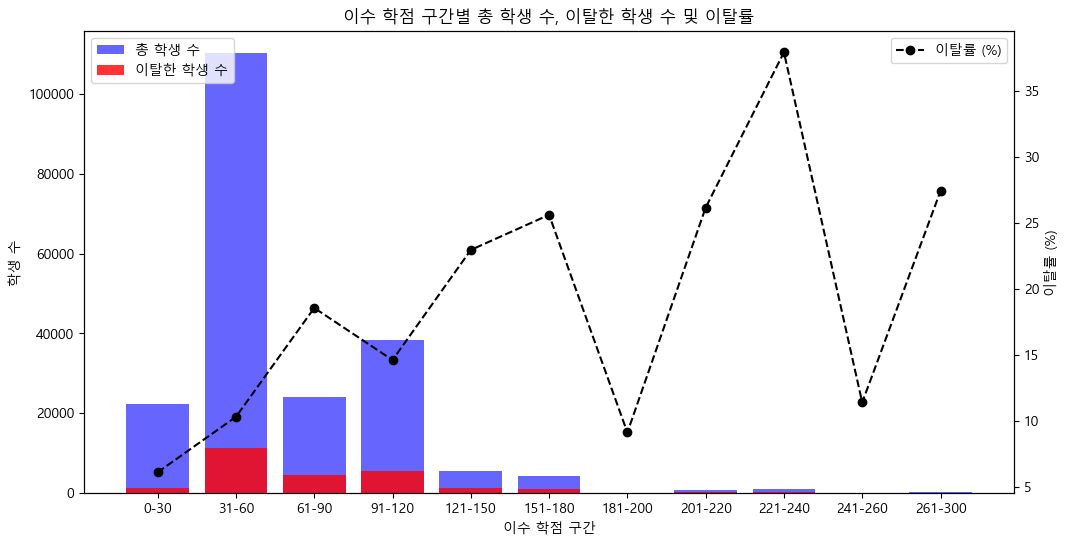

In [14]:
final_merged_data["credit_bins"] = pd.cut(final_merged_data["studied_credits"], bins=[0, 30, 60, 90, 120, 150, 180, 200, 220, 240, 260, 300], 
                                          labels=["0-30", "31-60", "61-90", "91-120", "121-150", "151-180", "181-200", "201-220", "221-240", "241-260", "261-300"])

credit_counts = final_merged_data["credit_bins"].value_counts().sort_index()
credit_withdrawn_counts = final_merged_data[final_merged_data["final_result"] == "Withdrawn"]["credit_bins"].value_counts().sort_index()

credit_df = pd.DataFrame({"총 학생 수": credit_counts, "이탈한 학생 수": credit_withdrawn_counts}).fillna(0)
credit_df["이탈률 (%)"] = (credit_df["이탈한 학생 수"] / credit_df["총 학생 수"]) * 100

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(credit_df.index, credit_df["총 학생 수"], color="blue", alpha=0.6, label="총 학생 수")
ax1.bar(credit_df.index, credit_df["이탈한 학생 수"], color="red", alpha=0.8, label="이탈한 학생 수")
ax1.set_ylabel("학생 수")
ax1.set_xlabel("이수 학점 구간")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(credit_df.index, credit_df["이탈률 (%)"], color="black", marker="o", linestyle="dashed", label="이탈률 (%)")
ax2.set_ylabel("이탈률 (%)")
ax2.legend(loc="upper right")

plt.title("이수 학점 구간별 총 학생 수, 이탈한 학생 수 및 이탈률")
plt.show()

In [15]:
final_merged_data = final_merged_data.drop(columns=['score_bins', 'credit_bins'], axis=1)


### Data Labeling

- final_result 컬럼을 이진 분류(Binary Classification) 형태로 변환.
- Withdrawn (중도 포기) → 0, 그 외 (Distinction, Fail, Pass) → 1
- 0 = 학습 포기 (Withdrawn)
- 1 = 학습 지속 (Pass, Fail, Distinction)
- code_module과 imd_band는 범주형 변수는 LabelEncoder()를 사용하여 각각의 고유한 문자열을 숫자로 변환.         

In [16]:
from sklearn.preprocessing import LabelEncoder

new_education_encodings = {
    'Post Graduate Qualification': 0,
    'HE Qualification': 1,
    'A Level or Equivalent': 2,
    'Lower Than A Level': 3,
    'No Formal quals': 4
}

final_merged_data['highest_education'] = final_merged_data['highest_education'].map(new_education_encodings)

final_merged_data.head(5)

new_final_result_encodings = {
    'Withdrawn': 0,
    'Distinction': 1,
    'Fail': 1,
    'Pass': 1
}

final_merged_data['final_result'] = final_merged_data['final_result'].map(new_final_result_encodings)

final_merged_data.head(20)

final_merged_data = final_merged_data.copy()
label_encoder = LabelEncoder()

categorical_columns = ["code_module", "imd_band",]
for col in categorical_columns:
    final_merged_data[col] = label_encoder.fit_transform(final_merged_data[col])

Text(0, 0.5, '빈도')

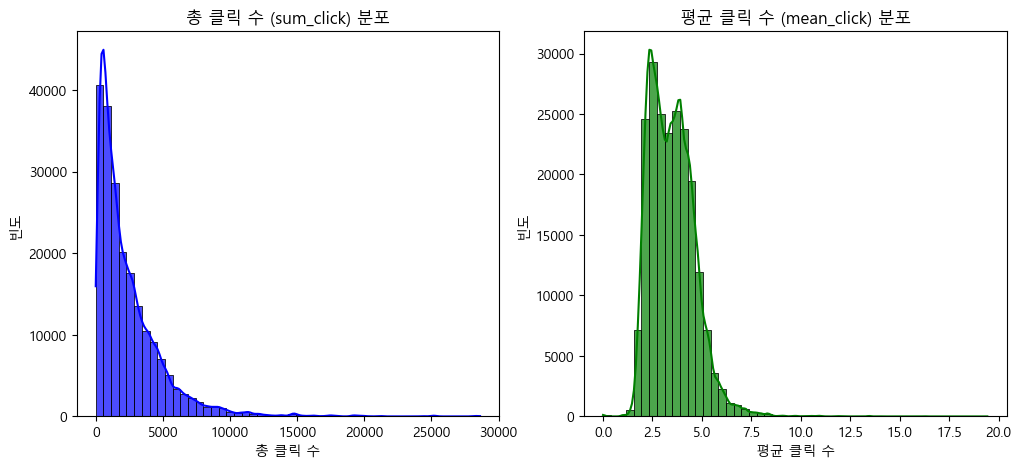

In [17]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(final_merged_data["sum_click"], bins=50, kde=True, color="blue", alpha=0.7)
plt.title("총 클릭 수 (sum_click) 분포")
plt.xlabel("총 클릭 수")
plt.ylabel("빈도")

plt.subplot(1, 2, 2)
sns.histplot(final_merged_data["mean_click"], bins=50, kde=True, color="green", alpha=0.7)
plt.title("평균 클릭 수 (mean_click) 분포")
plt.xlabel("평균 클릭 수")
plt.ylabel("빈도")

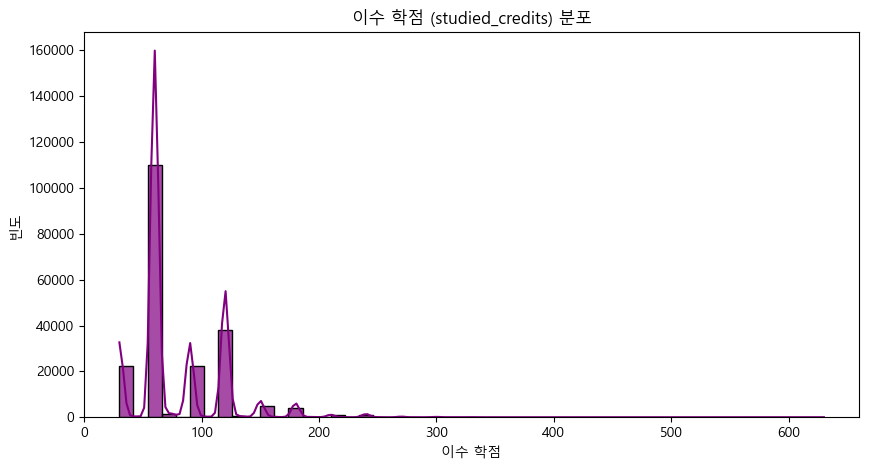

In [18]:
plt.figure(figsize=(10, 5))
sns.histplot(final_merged_data["studied_credits"], bins=50, kde=True, color="purple", alpha=0.7)
plt.title("이수 학점 (studied_credits) 분포")
plt.xlabel("이수 학점")
plt.ylabel("빈도")
plt.show()

### Data Scaling

- sum_click (총 클릭 수) → 오른쪽 꼬리가 긴 비대칭 분포 (Right-skewed)
- mean_click (평균 클릭 수) → 완만한 비대칭 분포지만, 특정 범위에 밀집

따라서, 분포를 정규 분포에 가깝게 변형하는 Log Scaling 진행

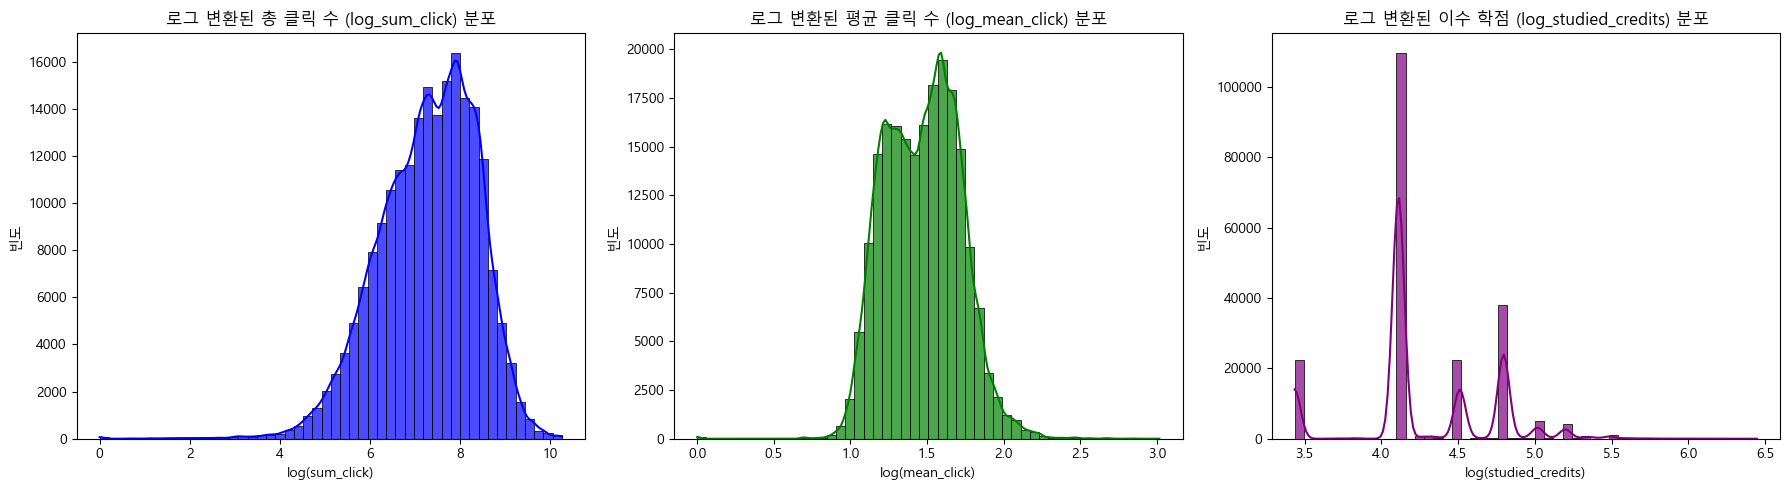

In [19]:
import numpy as np

final_merged_data["log_sum_click"] = np.log1p(final_merged_data["sum_click"])
final_merged_data["log_mean_click"] = np.log1p(final_merged_data["mean_click"])
final_merged_data["log_studied_credits"] = np.log1p(final_merged_data["studied_credits"])

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(final_merged_data["log_sum_click"], bins=50, kde=True, color="blue", alpha=0.7)
plt.title("로그 변환된 총 클릭 수 (log_sum_click) 분포")
plt.xlabel("log(sum_click)")
plt.ylabel("빈도")

plt.subplot(1, 3, 2)
sns.histplot(final_merged_data["log_mean_click"], bins=50, kde=True, color="green", alpha=0.7)
plt.title("로그 변환된 평균 클릭 수 (log_mean_click) 분포")
plt.xlabel("log(mean_click)")
plt.ylabel("빈도")

plt.subplot(1, 3, 3)
sns.histplot(final_merged_data["log_studied_credits"], bins=50, kde=True, color="purple", alpha=0.7)
plt.title("로그 변환된 이수 학점 (log_studied_credits) 분포")
plt.xlabel("log(studied_credits)")
plt.ylabel("빈도")

plt.tight_layout()
plt.show()

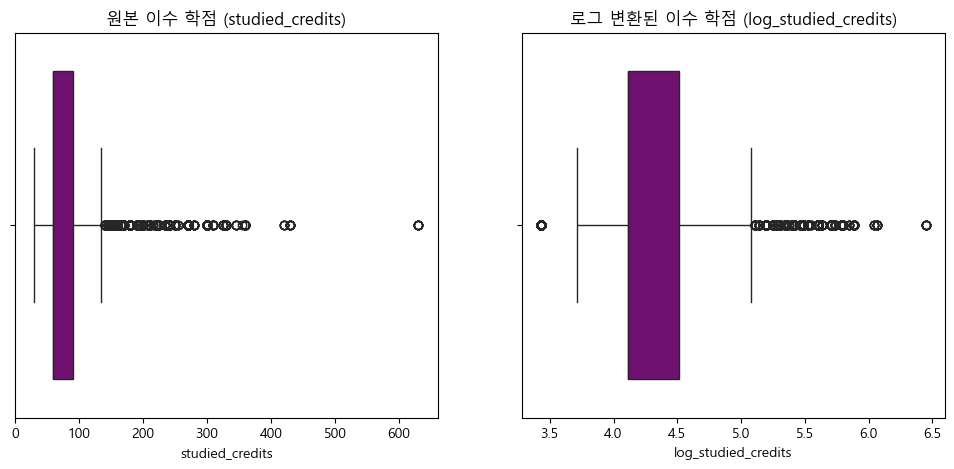

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=final_merged_data["studied_credits"], color="purple")
plt.title("원본 이수 학점 (studied_credits)")

plt.subplot(1, 2, 2)
sns.boxplot(x=final_merged_data["log_studied_credits"], color="purple")
plt.title("로그 변환된 이수 학점 (log_studied_credits)")

plt.show()

In [21]:
final_merged_data = final_merged_data[final_merged_data["log_studied_credits"] > 3.5]

Text(0.5, 1.0, '로그 변환된 이수 학점 (log_studied_credits)')

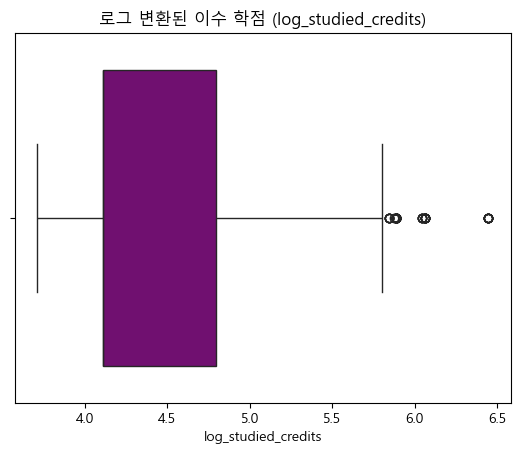

In [22]:
sns.boxplot(x=final_merged_data["log_studied_credits"], color="purple")
plt.title("로그 변환된 이수 학점 (log_studied_credits)")

#### MinMaxScaler
- 정규 분포를 따르지 않으므로 MinmaxScalar를 사용

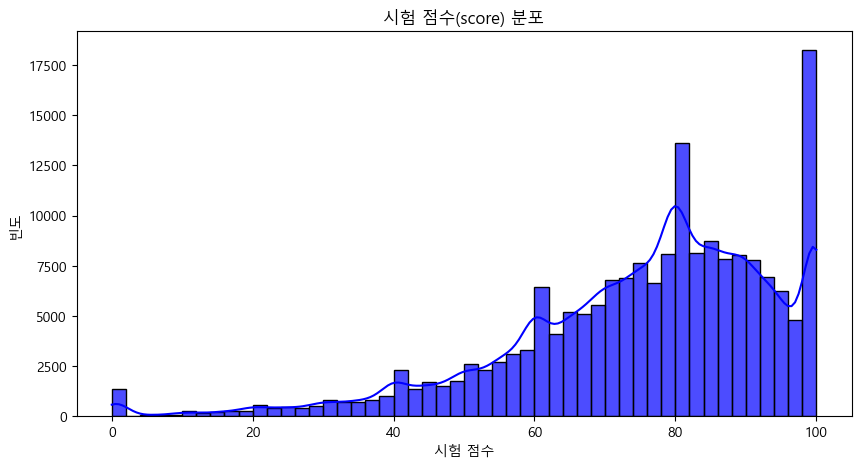

In [23]:
plt.figure(figsize=(10, 5))
sns.histplot(final_merged_data["score"], bins=50, kde=True, color="blue", alpha=0.7)
plt.title("시험 점수(score) 분포")
plt.xlabel("시험 점수")
plt.ylabel("빈도")
plt.show()

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
final_merged_data["scaled_studied_credits"] = scaler.fit_transform(final_merged_data[["studied_credits"]])
final_merged_data["scaled_score"] = scaler.fit_transform(final_merged_data[["score"]])

In [25]:
final_merged_data.to_csv('./data/final_merge_data', index=False)

### 학습 데이터

In [26]:
from sklearn.model_selection import train_test_split

sum_clicked_features = ['highest_education', 'imd_band', 'log_sum_click', 'log_studied_credits', 'scaled_score']
mean_clicked_features = ['highest_education', 'imd_band', 'log_mean_click', 'log_studied_credits', 'scaled_score']

sum_x = final_merged_data[sum_clicked_features]
mean_x = final_merged_data[mean_clicked_features]
y = final_merged_data['final_result']

sum_x_train, sum_x_test, y_train, y_test = train_test_split(sum_x, y, test_size=0.1, random_state=42, stratify=y)
mean_x_train, mean_x_test, y_train, y_test = train_test_split(mean_x, y, test_size=0.1, random_state=42, stratify=y)


# SUM

In [ ]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(sum_x_train, y_train)
lgb_preds = lgb_model.predict(sum_x_test)
print("LightGBM Accuracy:", accuracy_score(y_test, lgb_preds))
print(classification_report(y_test, lgb_preds))

# XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(sum_x_train, y_train)
xgb_preds = xgb_model.predict(sum_x_test)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))

# Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(sum_x_train, y_train)
gb_preds = gb_model.predict(sum_x_test)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, gb_preds))
print(classification_report(y_test, gb_preds))


In [33]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# LightGBM Hyperparameter Tuning
lgb_params = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'n_estimators': [100, 150, 200, 300, 500],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [5, 10, 20]
}
lgb_model = GridSearchCV(lgb.LGBMClassifier(random_state=42), lgb_params, cv=3, scoring='accuracy')
lgb_model.fit(sum_x_train, y_train)
lgb_preds = lgb_model.best_estimator_.predict(sum_x_test)
print("LightGBM Best Params:", lgb_model.best_params_)
print("LightGBM Accuracy:", accuracy_score(y_test, lgb_preds))
print(classification_report(y_test, lgb_preds))

[LightGBM] [Info] Number of positive: 96190, number of negative: 14759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 419
[LightGBM] [Info] Number of data points in the train set: 110949, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.866975 -> initscore=1.874472
[LightGBM] [Info] Start training from score 1.874472
[LightGBM] [Info] Number of positive: 96191, number of negative: 14758
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 110949, number of used features: 5
[LightGBM] [Info] [bin

In [ ]:
# # XGBoost Hyperparameter Tuning
# xgb_params = {
#     'max_depth': [3, 6],
#     'learning_rate': [0.01, 0.1],
#     'n_estimators': [100, 200]
# }
# xgb_model = GridSearchCV(xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'), xgb_params, cv=3, scoring='accuracy')
# xgb_model.fit(sum_x_train, y_train)
# xgb_preds = xgb_model.best_estimator_.predict(sum_x_test)
# print("XGBoost Best Params:", xgb_model.best_params_)
# print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
# print(classification_report(y_test, xgb_preds))


In [34]:
# Gradient Boosting Hyperparameter Tuning
gb_params = {
    'n_estimators': [100, 150, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10]
}
gb_model = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=3, scoring='accuracy')
gb_model.fit(sum_x_train, y_train)
gb_preds = gb_model.best_estimator_.predict(sum_x_test)
print("Gradient Boosting Best Params:", gb_model.best_params_)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, gb_preds))
print(classification_report(y_test, gb_preds))


Gradient Boosting Best Params: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 300}
Gradient Boosting Accuracy: 0.904553320354748
              precision    recall  f1-score   support

           0       0.68      0.53      0.60      2460
           1       0.93      0.96      0.95     16032

    accuracy                           0.90     18492
   macro avg       0.81      0.75      0.77     18492
weighted avg       0.90      0.90      0.90     18492



# MEAN

In [ ]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# LightGBM Hyperparameter Tuning
lgb_params = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [5, 10, 20]
}

lgb_model = GridSearchCV(lgb.LGBMClassifier(random_state=42), lgb_params, cv=3, scoring='accuracy')
lgb_model.fit(mean_x_train, y_train)
lgb_preds = lgb_model.best_estimator_.predict(mean_x_test)
print("LightGBM Best Params:", lgb_model.best_params_)
print("LightGBM Accuracy:", accuracy_score(y_test, lgb_preds))
print(classification_report(y_test, lgb_preds))

# # XGBoost Hyperparameter Tuning
# xgb_params = {
#     'max_depth': [3, 6],
#     'learning_rate': [0.01, 0.1],
#     'n_estimators': [100, 200]
# }

# xgb_model = GridSearchCV(xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'), xgb_params, cv=3, scoring='accuracy')
# xgb_model.fit(mean_x_train, y_train)
# xgb_preds = xgb_model.best_estimator_.predict(mean_x_test)
# print("XGBoost Best Params:", xgb_model.best_params_)
# print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
# print(classification_report(y_test, xgb_preds))

[LightGBM] [Info] Number of positive: 96190, number of negative: 14759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 419
[LightGBM] [Info] Number of data points in the train set: 110949, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.866975 -> initscore=1.874472
[LightGBM] [Info] Start training from score 1.874472
[LightGBM] [Info] Number of positive: 96191, number of negative: 14758
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 110949, number of used features: 5
[LightGBM] [Info] [bin

AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [37]:
# Gradient Boosting Hyperparameter Tuning
gb_params = {
    'n_estimators': [100, 150, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10]
}

gb_model = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=3, scoring='accuracy')
gb_model.fit(mean_x_train, y_train)
gb_preds = gb_model.best_estimator_.predict(mean_x_test)
print("Gradient Boosting Best Params:", gb_model.best_params_)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, gb_preds))
print(classification_report(y_test, gb_preds))

Gradient Boosting Best Params: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 300}
Gradient Boosting Accuracy: 0.9049859398658879
              precision    recall  f1-score   support

           0       0.70      0.50      0.59      2460
           1       0.93      0.97      0.95     16032

    accuracy                           0.90     18492
   macro avg       0.81      0.74      0.77     18492
weighted avg       0.90      0.90      0.90     18492

